[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/066_ssl/ssl.ipynb)

# Aprendizaje Auto-Supervisado

Hasta ahora hemos visto un montón de ejemplos y aplicaciones de redes neuronales, y en todas ellas hemos utilizado el mismo algoritmo de aprendizaje: el aprendizaje supervisado. Este tipo de aprendizaje se caracteriza por el acceso a un conjunto de datos etiquetado, consistente en pares de ejemplos de entradas y salidas. Un ejemplo muy sencillo de entender es el entrenamiento de un clasificador de imágenes, por ejemplo usando el dataset MNIST, que está compuesto por un conjunto de imágenes y cada una de ellas viene acompañada por su correspondiente etiqueta. Esto nos permite comparar para cada imagen del dataset la salida de nuestra red con la etiqueta real, el *ground truth*, y ajustar los parámetros internos del modelo de manera iterativa para que, poco a poco, las salidas sean lo más parecidas a las etiquetas.

Si bien este proceso es muy utilizado y ha dado muy buenos resultados en muchas aplicaciones, existen muchas otras en las que tales datasets etiquetados simplemente no existen o son escasos debido al coste y la complejidad de elaborarlos. Un ejemplo es el entrenamiento de redes neuronales para tareas de visión artificial en imágenes de satélite. Si queremos, por ejemplo, un detector de coches para calcular la ocupación de aparcamientos necesitaremos, primero, comprar imágenes de alta resolución (que pueden llegar a costar varios miles de euros cada una) y, segundo, etiquetar todos los coches que encontremos en las imágenes (lo cual puede llevar un buen rato). Es en este punto en el que nos preguntamos: ¿es posible entrenar redes neuronales sin etiquetas, solo a partir de datos? A este campo se le conoce como aprendizaje no supervisado, *unsupervised learning* en inglés, y es lo que vamos a explorar en este y los siguientes posts.

## La analogía del pastel de *Yan Lecun*

Uno de los investigadores más influyentes en el ámbito del aprendizaje no supervisado, y del mundo del aprendizaje profundo en general, es Yann Lecun. Para entender la potencia de esta forma de aprendizaje presentó una analogía en la que, si el aprendizaje fuese un pastel, el aprendizaje supervisado solo correspondería al recubrimiento, mientras que el aprendizaje no supervisado sería el interior (y el aprendizaje por refuerzo, la cereza de arriba 😝)

![](https://miro.medium.com/max/4416/1*bvMhd_xpVxfJYoKXYp5hug.png)

Esto nos da una idea de la importancia de ser capaces de entrenar nuestros modelos sin necesidad de un dataset etiquetado. Poder llevar a cabo este mecanismo de manera efectiva abriría la puerta a muchas aplicaciones hoy en día inconcebibles.

Si bien en el campo del *machine learning* existen diferentes algoritmos no supervisados, como algoritmos de clustering (K-Means, DBSCAN, ...), estimación de probabilidad (Gaussian Mixtures) o reducción de dimensionalidad (PCA y otros), los algoritmos no supervisados para *deep learning* son a día de hoy un tema de investigación muy activa, siendo los algoritmos de aprendizaje auto-supervisado (*self-supervised learning*) los más comunes por sus buenos resultados.


## Aprendizaje Auto-Supervisado

El aprendizaje auto-supervisado consiste en el entrenamiento de modelos que aprenden representaciones invariantes a distorsiones de la misma entrada. Esto significa que si un modelo es alimentado por una imagen en color y la misma imagen en blanco y negro, la representación interna (las *features* que nos daría el modelo justo antes del clasificador) debería ser igual, o lo más parecida posible. Diferentes métodos se basan en esta idea para construir, de una manera u otra, una función de pérdida que compare estas representaciones y minimize la diferencia entre pares de transformaciones que provengan de la misma imagen, mientras que maximice la diferencia entre imágenes diferentes. Algunos de los métodos más conocidos son:

- Moco
- SwAV
- SimCLR

En este post vamos a ver un ejemplo utilizando un método simple y reciente (a la hora de elaborar este post): [Barlow Twins](https://arxiv.org/abs/2103.03230). Pero antes, vamos a demostrar la necesidad de esta técnica.

## CIFAR10

Vamos a entrenar una red neuronal convolucional sencilla para la clasificación de imágenes con el dataset [CIFAR10](https://arxiv.org/abs/2103.03230).

hacerlo con pytorch a pelo

In [1]:
import torch
import torchvision
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True, trans=None):
        self.trans = trans
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        if self.trans:
            imgs = self.trans(image=img)['image']
        return torch.from_numpy(img / 255.).permute(2,0,1).float(), torch.tensor(self.labels[ix]).long()

In [2]:
ds = {
    'train': Dataset(),
    'test': Dataset(train=False)
}

ds['train'].imgs.shape, ds['test'].imgs.shape, 

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [3]:
batch_size = 32

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=4)
} 

In [4]:
imgs, labels = next(iter(dl['train']))
imgs.shape, labels.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

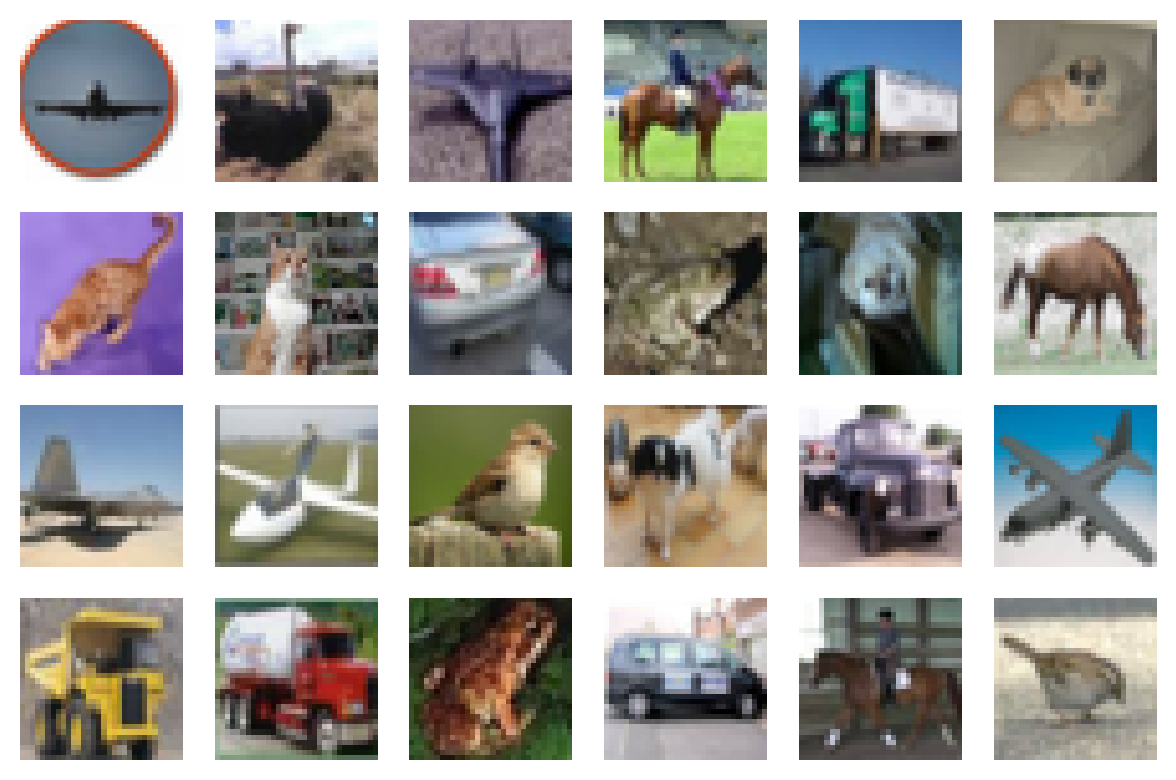

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img.permute(1,2,0))
        ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
import torch.nn.functional as F

def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

class Model(torch.nn.Module):

    def __init__(self, n_channels=3, n_outputs=10):
        super().__init__()
        self.conv1 = block(n_channels, 64)
        self.conv2 = block(64, 128)
        self.conv3 = block(128, 256)
        self.fc = torch.nn.Linear(256*4*4, n_outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [7]:
model = Model()
output = model(torch.randn(32, 3, 32, 32))

output.shape

torch.Size([32, 10])

In [12]:
from tqdm import tqdm 

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cuda"):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        for batch in bar:
            optimizer.zero_grad()
            loss, acc = step(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        # eval
        model.eval()
        l, a = [], []
        bar = tqdm(dl['test'])
        with torch.no_grad():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['test_loss'].append(np.mean(l))
        hist['test_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
    return hist

In [37]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

hist = train(model, dl, optimizer, epochs=10)

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1/10 loss 1.4717 acc 0.4707 test_loss 1.2110 test_acc 0.5612


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2/10 loss 1.0831 acc 0.6216 test_loss 1.0088 test_acc 0.6421


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3/10 loss 0.9122 acc 0.6831 test_loss 0.9054 test_acc 0.6925


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4/10 loss 0.8037 acc 0.7228 test_loss 0.8484 test_acc 0.7110


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5/10 loss 0.7183 acc 0.7514 test_loss 0.7913 test_acc 0.7278


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6/10 loss 0.6444 acc 0.7796 test_loss 0.7608 test_acc 0.7424


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7/10 loss 0.5767 acc 0.8030 test_loss 0.7605 test_acc 0.7437


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8/10 loss 0.5166 acc 0.8230 test_loss 0.7396 test_acc 0.7503


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9/10 loss 0.4630 acc 0.8424 test_loss 0.7685 test_acc 0.7519


testing... loss 0.8192 acc 0.7389: 100%|██████████| 313/313 [00:00<00:00, 365.52it/s]

Epoch 10/10 loss 0.4055 acc 0.8616 test_loss 0.8192 test_acc 0.7389


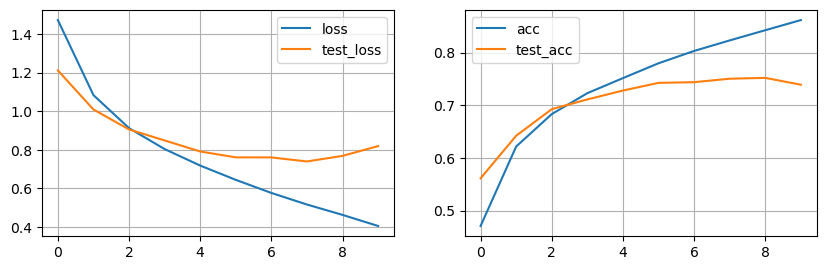

In [38]:
import pandas as pd

fig = plt.figure(figsize=(10, 3), dpi=100)
df = pd.DataFrame(hist)
ax = plt.subplot(1, 2, 1)
df[['loss', 'test_loss']].plot(ax=ax)
ax.grid(True)
ax = plt.subplot(1, 2, 2)
df[['acc', 'test_acc']].plot(ax=ax)
ax.grid(True)
plt.show()

Llegamos al 70%, podemos hacerlo mejor ? Hemos entrenado from scratch, sabemos que el transfer learnig funciona mejor. Podríamos usar imagenet, pero las imágenes son muy diferentes. Podemos pre-entrenar la red ?

Que pasa si entrenamos con el 1% o 10% de las etiquetas ?